<font size = 7>DELE ST1504 CA2 Part B: Reinforcement Learning </font>
<hr>
<font size = 4>
Name: Lee Hong Yi & Yadanar Aung<br>
Admin No: 2223010 & 2214621<br>
Class: DAAA/FT/2B/07<br>
</font>
<hr>

**Objective:**  
Develop a model using a <U>modified Deep Q-Network (DQN)</U> architecture to <u>balance a pendulum</u>. The model should apply <u>suitable torque</u> to maintain the pendulum in an <u>upright position</u>. The primary focus is on demonstrating the effectiveness of the DQN in this context, with the possibility of exploring other reinforcement learning architectures after the successful implementation of DQN.

**Background:**  
Deep Q-Networks are a class of deep reinforcement learning algorithms that <u>combine Q-Learning with deep neural networks</u>. This project aims to apply DQN to the classic control problem of pendulum balancing, a benchmark challenge in the reinforcement learning field. The goal is to train a model that can learn the optimal strategy to keep the pendulum balanced by applying the correct amount of torque.

**Key Features:** <br>
Implement a modified version of the DQN algorithm to specifically address the dynamics of pendulum balancing, using the <u>Pendulum environment from OpenAI Gym</u>, which provides a standardized platform for testing the model's performance.

**Output Specification:**  
The output specification for this Deep Q-Network (DQN) project focused on balancing a pendulum entails the generation of <u>control actions</u> in the form of torque values, which are applied at each timestep to maintain the pendulum's upright position. These actions, derived from the model's learning process, will be complemented by performance metrics demonstrating the learning progression, such as episode duration, balance efficiency, and torque magnitude. Additionally, the model will provide visualizations of the pendulum's state and behavior over time, as well as detailed evaluation metrics like <u>average reward per episode</u> and <u>loss over time</u>. The final output includes the <u>learned policy</u>, represented either through model weights or a graphical depiction, showcasing the model's effectiveness in learning and applying the optimal strategy for pendulum balance.

<hr>
<font size = 5>Performing initial set-up</font>
<hr>

In [1]:
%load_ext autoreload
%autoreload 1
%aimport rlfunction

import os
import gc
import gym
import time as time_module
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython import display as ipythondisplay
from IPython.display import HTML
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import rlfunction as rlf

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)     
simplefilter(action='ignore', category=FutureWarning) 
simplefilter(action='ignore', category=DeprecationWarning)

sns.set_style()
sns.set_style('darkgrid')

In [3]:
# Fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(0)  

In [4]:
# Check GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')

# Memory control: Prevent tensorflow from allocating totality of GPU memory
for gpu in gpus:
    try:
        print(tf.config.experimental.get_device_details(gpu))
    except:
        pass
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPU(s) present.")

There are 0 GPU(s) present.


<hr>
<font size = 5>Background Research</font>
<hr>

We will be working with the <u>Pendulum environment</u> from OpenAI Gym. 

A pendulum is attached at one end to a fixed point, with the other end free. The pendulum starts in any random position. The goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

<img src='https://www.gymlibrary.dev/_images/pendulum.gif' width=300 height=300> 
<br><br>

<table>
  <tr>
    <td>Action Space</td>
    <td>Box(-2.0, 2.0, (1,), float32)</td>
  </tr>
  <tr>
    <td>Observation Shape</td>
    <td>(3,)</td>
  </tr>
  <tr>
    <td>Observation High</td>
    <td>[1. 1. 8.]</td>
  </tr>
  <tr>
    <td>Observation Low</td>
    <td>[-1. -1. -8.]</td>
  </tr>
</table>

<br>

The figure below specifies the coordinate system used for the implementation of the pendulum's dynamic equations.

<img src='https://gymnasium.farama.org/_images/pendulum.png'> 

- `x-y`: Cartesian coordinates of the pendulum’s end in meters.
- `theta`: Angle in radians.
- `tau`: Torque in N m. Defined as positive <i>counter-clockwise</i>.

<br>

The <b>Action space is <u>continuous</u></b>, with an infinite number of actions. The action is ndarray with shape (1,), which represents the torque applied to the free end of the pendulum.
<table>
  <tr>
    <th>Num</th>
    <th>Action</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Torque</td>
    <td>-2.0</td>
    <td>2.0</td>
  </tr>
</table>

<br>

The <b>State space is <u>continuous</u></b>. The observation is a ndarray with shape (3,), which represents the x-y coordinates of the pendulum's free end and its angular velocity.
<table>
  <tr>
    <th>Num</th>
    <th>Observation</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
  <tr>
    <td>0</td>
    <td>x = cos(theta)</td>
    <td>-1.0</td>
    <td>1.0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>y = sin(angle)</td>
    <td>-1.0</td>
    <td>1.0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Angular Velocity</td>
    <td>-8.0</td>
    <td>8.0</td>
  </tr>
</table>

<br>

The <b>Reward</b> function is defined as: <i>r = -(theta^2 + 0.1 * theta_dt^2 + 0.001 * torque^2)</i>
- Where `theta` is the pendulum’s angle normalized between [-pi, pi] (with 0 being in the upright position)
- Min reward: -(pi^2 + 0.1 * 8^2 + 0.001 * 2^2) = -16.2736044
- Max reward: 0 (pendulum is upright with zero velocity and no torque applied)

The <b>Starting State</b> is a random angle in <i>[-pi, pi]</i> and a random angular velocity in <i>[-1,1]</i>.

The <b>Episode Truncates</b> at 200 time steps.

Source: https://www.gymlibrary.dev/environments/classic_control/pendulum/

<hr>
<font size = 5>OpenAI Gym</font>
<hr>

OpenAI Gym is an open source toolkit to develop and compare Reinforcement Learning (RL) algorithms. It contains a variety of simulated environments that can be used to train agents and develop new RL algorithms.

<h3>Create Environment for Agent from OpenAI Gym</h3>

In [5]:
# Initialize the environment with specified render mode
env = gym.make('Pendulum-v1', render_mode='rgb_array')

# Set the environment to the initial state
env.reset()
frames = []
reward_arr = []

# Run the simulation for 50 time steps
for _ in range(50):
    # Take a random action
    action = env.action_space.sample()
    _, reward, _, *_ = env.step(action)
    reward_arr.append(reward)
    frame = env.render()
    frames.append(frame)

# Close the environment
env.close()

ani = rlf.create_animation(frames)
print(f"Reward for test episode (random): {np.mean(reward_arr)}")
HTML(ani.to_jshtml())
# display(ani)

Reward for test episode (random): -8.85457080267795


<hr>
<font size = 5>Reinforcement Learning</font>
<hr>

Reinforcement Learning (RL) is a type of machine learning technique that focuses on how agents learn to interact with an environment, by trial and error using feedback from its own actions and experiences, to maximize cumulative rewards.

The Goal of RL is for the Agent to strive to <b><i>maximize expected return</i></b>.
- where <i><b><mark>Return G = Immediate reward R + discounted future reward γ</mark> </b></i>(multipled by discount factor <1 [0.9], due to future uncertainty)

The figure below illustrates the action-reward feedback loop for a typical RL model.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*7cuAqjQ97x1H_sBIeAVVZg.png' width=700>

There are certain concepts, assumptions & set-up in RL:

- <b><u>Episode</u></b>: A sequence of states and actions.

- <b><u>Environment, e</u></b>: The Environment provides a <i><b>state S</b></i>, for the agent to nagivate. It provides a particular <i><b>set of actions at each state A(S)</b></i>, for the agent. It provides <b><i>reward R per action</i></b>, for the agent. It is assumed to be stationary. It only cares about the current state, i.e. the history or how the agent got there is irrelevant.
    - There are conditions necessary for RL to converge to a solution:
        1. Stationary Environment
        2. Appropriate Learning Rate (Set high at the beginning) and Discount Factor
        3. Q(S,A)new = (1-α)Q(S,A)old + α(R+γQ(S,A)future)

- <b><u>Agent</u></b>: The agent navigates the environment. It only knows its current state S, the set of available actions at current state A(S), and the reward after taking an action. It receives immediate rewards R from the environment. The Agent should explore other better unknown solutions

- <b><u>Policy</u></b>: Method to map agent's state to actions. It determines how the agent behaves from a specific state.

- <b><u>Value / State-value function, V(S)</u></b>: Expected return, at state S

- <b><u>Q-value / Action-value function, Q(S,A)</u></b>: Expected return, at state S, taking action A

- <b><u>Update rule</u></b>: Q(S,A)new = (1-α)Q(S,A)old + α(R+γQ(S,A)future) 
    - Where α : learning rate.

- <b><u>Discount Factor, γ</u></b>: Weighs the contribution of future to immediate rewards, and is used to encourage agents to discover optimal solutions.

<br>

There are two types of RL Algorithms.

1. <b>Model-free</b>: Estimates optimal policy without using the dynamics of the environment
2. <b>Model-based</b>: Estimates optimal policy using dynamics of the environment (transition and reward function).<br><br>
<img src='https://www.ejable.com/wp-content/uploads/2023/11/5a.webp' width=800>

<br>

Before we move on, there is one important topic to cover: <b><u>The Exploration/Exploitation trade-off</u></b>.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/expexpltradeoff.jpg' width=500>

Exploration is where the agent tries random actions while exploring the evnironment, in order to improve its information about the environment, and gain better rewards in the long run.

Exploitation is where the agent exploits already known information of the environment to maximize reward immediately, even if it's a sub-optimal behavior.

If we were to focus on exploitation, our agent will only exploit the nearest known source of rewards, even if the source is small, hence taking the risk to miss another reward. But if our agent explores more, it can discover the probable opportunity of bigger rewards.

This introduces exploration/exploitation trade-off, as there is a need to balance how much the agent explores the environment, and how much the agent will explloit what we know about the environment. Hence, defining a rule to keep a balance between exploration and exploitation can help to handle this trade-off.


Sources:<br>
https://towardsdatascience.com/reinforcement-learning-101-e24b50e1d292<br>
https://medium.com/intro-to-artificial-intelligence/key-concepts-in-reinforcement-learning-2af715dfbfa<br>
https://www.ejable.com/tech-corner/ai-machine-learning-and-deep-learning/q-learning/<br>
https://huggingface.co/learn/deep-rl-course/unit1/exp-exp-tradeoff

<hr>
<font size = 5>Deep Q-Network (DQN)</font>
<hr>

<b>Deep Q-Networks</b> is a RL technique that combines <b>Q-Learning</b>, an algorithm for <u>learning optimal actions</u> in an environment by <u>learning from their experiences</u>, with deep neural networks. DQN is the first deep reinforcement learning method proposed by <a href="https://deepmind.google/discover/blog/deep-reinforcement-learning/">DeepMind</a> in 2015. Due to techniques used in DQN, it is known to empower RL to directly deal with high dimensional states such as images.

<h4><b>Q-Learning</b></h4>

Q-learning is a model-free, off-policy and temporal difference (TD) control approach, aimed to find the next best action to maximize the reward. It maps state-action pairs to the highest combination of immediate reward with all future rewards that might be harvested by later actions in trajectory. It is where the agent strives to maximize return, by learning the Q-values for each state-action pair. In other words, it is a cheat sheet for the agent. 

It is a <u>value-based</u> learning algorithm, revolving around the notion of updating <u>Q-values Q(S,A)</u>, which denotes the value of performing action a in state s. Q-learning iteratively and continuously updates its Q-values assoicated with state-action pairs based on the Bellman equation. It continuously adjusts and optimizes as it experiences new states and rewards. 

It is an off-policy approach as it estimates the reward for the state-action pairs based on the value of the optimal (greedy) policy, independent of the agent's actions. 

The figure below is the <b>Bellman Equation</b> of the value update rule, which is the core of the Q-learning alogrithm: 

<img src='https://www.ejable.com/wp-content/uploads/2023/10/3a1.webp'>

The Bellman Equation captures the relationship between the current value of a state, and the potential future rewards that an action can yield. It establishes a recursive relationship that ties the value of a current state and action to the anticipated rewards of the subsequent states, similar to the concept of a chess game. This feature continuously propagates values backward from a rewarding future to earlier decisions.

As the agent explores the environment, it uses the Bellman Equation to update its estimates, calculating and recalculating Q-values to discover new experiences, and varied outcomes. Hence, it learns more about the environment's reward structure.

<b>Q-table</b> is a lookup table to help determine which path is the best after the Q-learning attempts multiple paths. The Q-table stores the calculated maximum expected future rewards, finding the best action for each state in the environment. Hence, the agent knows the expected reward of each action at every step. This allows are comparison to the other states. 

The figure below shows an example of how the Q-table works:

<img src='https://miro.medium.com/v2/resize:fit:1400/1*f8PhlUiGYVv_FJcgyFNGfw.png' width=800 height=400>

The flowchart below demonstrates the worflow of the Q-learning: 

<img src='https://cdn-media-1.freecodecamp.org/images/oQPHTmuB6tz7CVy3L05K1NlBmS6L8MUkgOud' width=500>

However, it can be limited to the size of state space, making it infeasible for very large state spaces.


<h4><b>Deep Q-Networks (DQNs)</b></h4>

This is where Deep Q-Learning enters to enable agents to learn optimal actions in complex, high-dimensional environments as it can handle environments with large state spaces. 

DQNs uses neural networks to <u>estimate Q-values</u>, which is the expected cumulative reward for each action in a given state. The network is updated iteratively throught episodes, using a combination of exploration and exploitation strategies. Its input is a state of the environment, and its output is the Q-value of all possible actions for the current state.

The figure below illustrates the comparison between Q-learning and Deep Q-learning:

<img src='https://www.baeldung.com/wp-content/uploads/sites/4/2023/04/dql-vs-ql-1.png'>

The steps involved in DQNs are:
1. All the past experience is stored in memory
2. The next action is determined by the maximum output of the Q-network
3. The loss function is the mean squared error of the predicted Q-value and the target Q-value – Q*. This is essentially a regression problem. The box in green represents the target in the figure below:
    <br><br><img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/04/Screenshot-2019-04-16-at-6.02.08-PM.png'>

However, DQN can suffer from instability during the training due to the non-stationary problem caused by the frequent updates of the neural network.

Sources:<br>
https://www.ejable.com/tech-corner/ai-machine-learning-and-deep-learning/q-learning/<br>
https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/#:~:text=overrides%20old%20information.-,What%20is%20Deep%20Q%2DLearning%3F,environment%2C%20with%20deep%20neural%20networks.<br>
https://towardsdatascience.com/reinforcement-learning-101-e24b50e1d292<br>
https://medium.com/mlearning-ai/everything-you-need-to-know-about-reinforcement-learning-c7c2d333ed7a<br>
https://towardsdatascience.com/welcome-to-deep-reinforcement-learning-part-1-dqn-c3cab4d41b6b<br>
https://www.baeldung.com/cs/epsilon-greedy-q-learning

However, DQN struggles with handling continuous action space and can be computationally expensive. Hence, there is a need for us to discretisize this envrionment in order for DQN to function. To do so, we are going to create bins, where the number of bins equals to the number of actions, e.g. -1 to -1.6 is a bin.

In [6]:
# Discretize the action space
state_size = env.observation_space.shape[0]
num_discrete_actions =  10
action_bounds = env.action_space.high[0]  # Assuming symmetric bounds
discrete_actions = np.linspace(-action_bounds, action_bounds, num_discrete_actions)

To note, one downside of this is that the reward is capped as the torque applied is capped. Based on online articles, deep deterministic policy gradient (DDPG) would work better with this continuous environment.

<hr>
<font size = 5>Approach(es) Taken</font>
<hr>

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/04/Screenshot-2019-04-17-at-1.15.28-PM.png' height=400 width=800>

DQN maintains stable learning with the following techniques:

1. <b>Experience Replay using Replay Memory</b>

https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial#introduction

This was proposed in the paper <a href="https://www.semanticscholar.org/paper/Reinforcement-learning-for-robots-using-neural-Lin/54c4cf3a8168c1b70f91cf78a3dc98b671935492?p2df">Reinforcement Learning For Robots Using Neural Networks</a> in 1992. DNN easily overfits current episodes, making it difficult to explore new experiences. 

<b><i>Experience Replay</i></b> helps to store experiences, rewards, and actions after every step that the agent performs, which are necessary data to perform Q-learning, and makes <u>mini-batches to update the neural networks</u>. 

<b><i>Replay Memory</i></b> is the memory that stores the agent's experiences as 𝑒𝑡=(𝑠𝑡,𝑎𝑡,𝑟𝑡,𝑠𝑡+1) [current_state, current_action, step_reward, next_state] in a dataset. This Replay Memory is used to train the DQN by using random subsets of the replays as inputs to help with generalizing, instead of simply using the most recent experience. This is because using sequential replays leads to the DQN overfitting.

This technique helps to <U>break the correlation between consecutive samples of experiences</U> in updating DQN. Experience Replay also <u>increases learning speed</u> with mini-batches, and <u>reuses past transitions</u> so that the model can learn more to avoid catastrophic forgetting.

<br>

2. <b>Target Network</b>

In Temporal Difference error calculation, the target function is continuously changing with updates to the Q-network during training as it is calculating both the predicted and target value, thus leading to a lot of divergence between these two. This unstable target function makes training difficult. Hence, a Target Network is a less frequent updated network, that fixes parameters of the target function and replaces them with the latest network every thousands steps to compute targets. This keeps the target function from changing too quickly. This stabilizes the learning process by providing <u>more consistent targets</u> for the Q-network.<br><br>
<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/04/Screenshot-2019-04-17-at-12.48.05-PM.png' height=400 width=500>


<br>

3. <b>Decayed Epsilon-Greedy Policy</b> (acting policy)

In Epsilon-Greedy action selection, the agent strives to have a balance, and use both exploitation to take advantage of prior knowledge, and exploration to look for new options.

Epsilon refers to the probability of choosing to explore, exploit most of the time with a small chance of exploring

With probability 1 - ɛ : Do exploitation (agent selects the action with the highest state-action pair value).

With probability ɛ: Do exploration (agent tries a random action)

We will set the epsilon value starting from 1.0. This is to allow the agent to explore the environment via random actions, as the agent has not learned anything meaningful in terms of associating higher Q-values to certain controls in different states, as it has yet to collect enough experience.

As the training continues, we will progressively <u>reduce the epsilon value since we will need lesser exploration</u>, and more exploitation of the agent's knowledge through the Q-values to choose actions that are optimal in the environment, after the agent has gained enough experience of the environment.

This idea is illustrated in the figure below.

<img src='https://www.baeldung.com/wp-content/uploads/sites/4/2020/12/q-learning-epsilon-greedy-1.png' width=400 height=400>

<br>

4. <b>RMSprop or Adam Optimizer</b>


Sources: <br>
https://towardsdatascience.com/welcome-to-deep-reinforcement-learning-part-1-dqn-c3cab4d41b6b<br>
https://towardsdatascience.com/deep-reinforcement-learning-with-python-part-2-creating-training-the-rl-agent-using-deep-q-d8216e59cf31<br>
https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/#:~:text=overrides%20old%20information.-,What%20is%20Deep%20Q%2DLearning%3F,environment%2C%20with%20deep%20neural%20networks<br>
https://conferences.oreilly.com/artificial-intelligence/ai-ca-2018/cdn.oreillystatic.com/en/assets/1/event/282/Evaluate%20deep%20Q-learning%20for%20sequential%20targeted%20marketing%20with%2010-fold%20cross-validation%20Presentation.pdf <br>
https://huggingface.co/learn/deep-rl-course/en/unit2/hands-on#define-the-epsilon-greedy-policy-<br>
https://medium.com/@CalebMBowyer/strategies-for-decaying-epsilon-in-epsilon-greedy-9b500ad9171d

<hr>
<font size = 5>Evaluation Methodology</font>
<hr>

We will be using Average Reward Per Episode to evaluate the performance of the agent. If the agent is improving in performance, then the average reward would be increasing. The reason why we are not simply using the accumulative rewards per episode is because, while Q-values can be used to compare actions, they are not meaningful in representing the performance of the agent as there is no benchmark.

Source:<br>
https://ai.stackexchange.com/questions/21182/how-to-evaluate-a-deep-q-network

<hr>
<font size = 5>Initial Modelling</font>
<hr>

<hr>
<font size = 5>DQN</font>
<hr>

<img src='https://www.researchgate.net/publication/327045314/figure/fig4/AS:819677282455553@1572437701142/Structure-of-the-neural-network-used-for-the-Deep-Q-learning-Network-implementation-with.png' width=600>

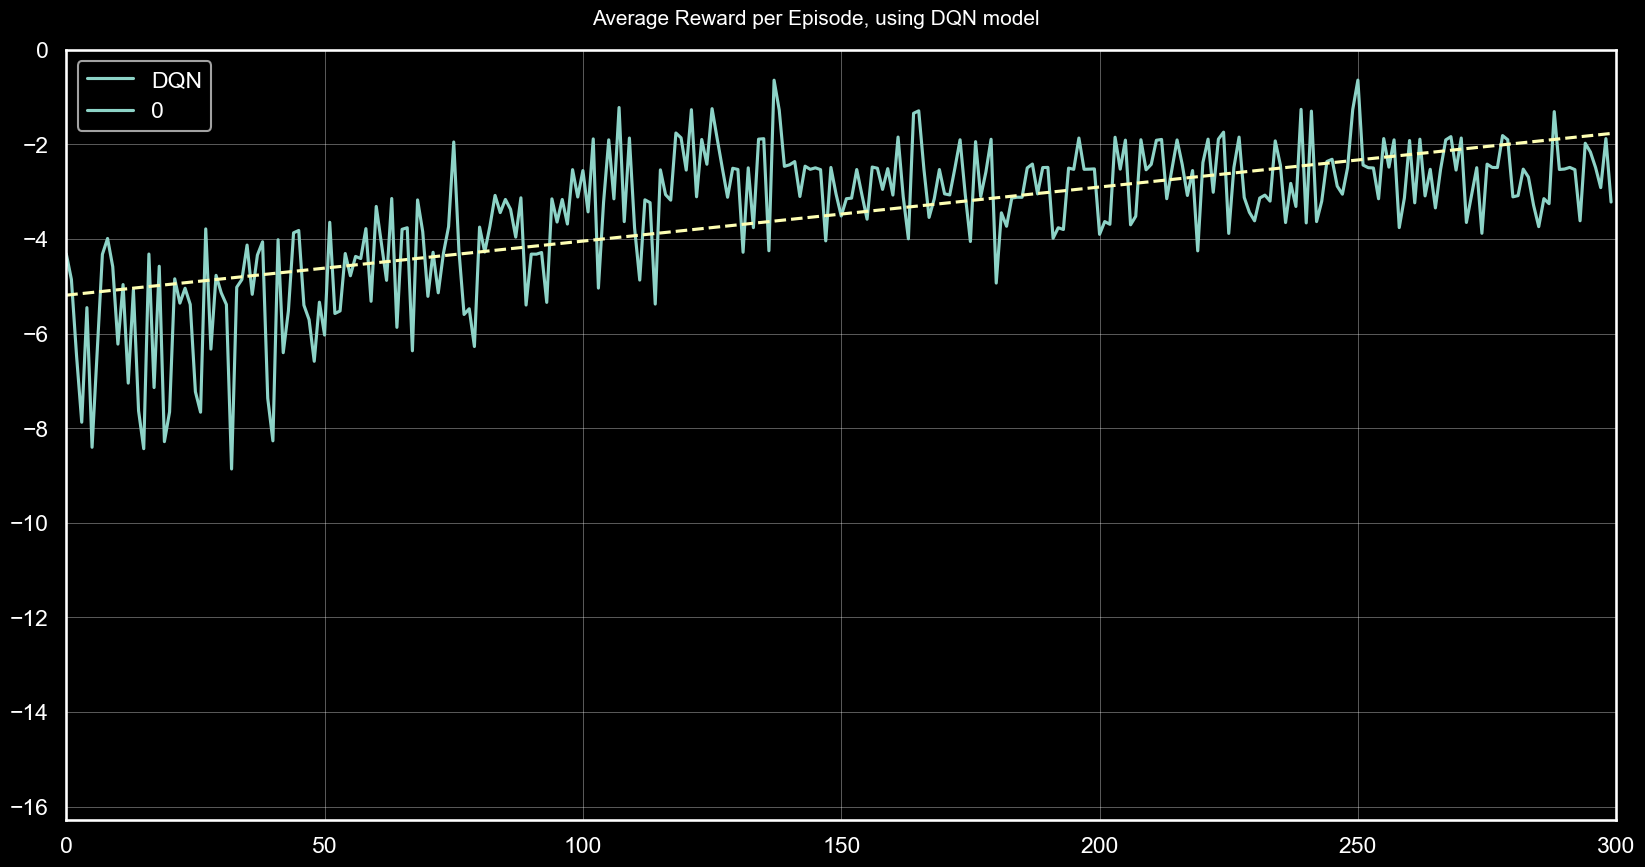

Average reward for test episode: -1.3481671837691267


In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, epsilon_decay=0.995, epsilon_min=0.02):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # Replay memory
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.update_target_model()

    # Model Architecture
    def _build_model(self):
        # Init model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        return model

    # Target Network
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Add to replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Epsilon-Greedy Policy to choose action
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # pull random action (exploration)
            return random.randrange(self.action_size)
        # else pull current-best action (greedy; exploitation)
        act_values = self.model.predict(state, verbose = 0)
        return np.argmax(act_values[0])

    # Replay Buffer
    def replay(self, batch_size):
        # Generate minibatches from replay memory for training data
        minibatch = random.sample(self.memory, batch_size)

        # Extract elements from minibatch
        states = np.array([x[0] for x in minibatch]) # Get states from training data
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch]) # Get future states from training data
        dones = np.array([x[4] for x in minibatch])

        # Ensure the states and next_states are correctly shaped
        states = np.reshape(states, (batch_size, self.state_size))
        next_states = np.reshape(next_states, (batch_size, self.state_size))

        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor([float(x[4]) for x in minibatch], dtype=tf.float32)
        dones_bool = tf.cast(dones, dtype=tf.bool)
        
        # Now using dones_bool as the condition
        # Faster training of neural networks
        with tf.GradientTape() as tape:
            target_q_values = rewards + self.gamma * tf.reduce_max(self.target_model(next_states, training=False), axis=1)
            target_q_values = tf.where(dones_bool, rewards, target_q_values)
            q_values = tf.reduce_sum(self.model(states, training=True) * tf.one_hot(actions, self.action_size), axis=1)
            loss = tf.reduce_mean(tf.square(target_q_values - q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    # Train model
    def train(self, train_length=300, batch_size=32):
        env = gym.make('Pendulum-v1') # Create environment
        done = False
        rewards = []
        average_rewards = []

        for e in range(train_length):
            start_time = time_module.time()
            reward_sum = 0
            state, info = env.reset() #reset environment
            state = np.reshape(state, [1, self.state_size]) # preprocess state

            for time in range(200):
                action = self.act(state) # choose action
                next_state, reward, _, done, _ = env.step([discrete_actions[action]])
                reward = reward if not done else -10

                next_state = np.reshape(next_state, [1, self.state_size]) # preprocess next state
                self.remember(state, action, reward, next_state, done) # store experience in replay memory
                state = next_state # move onto next state
                
                if done:
                    self.update_target_model()
                    rewards.append(time)
                    break
                # Only train if replay memory has enough data
                if len(self.memory) > batch_size:
                    self.replay(batch_size) # Get batch of data for training

                reward_sum += reward

            average_rewards.append(reward_sum / 200)
            print(f"Episode {e+1}, Epsilon: {self.epsilon:.3f}, Average Episode Reward: {(reward_sum / 200):.4f}, Duration = {time_module.time() - start_time:.2f} seconds", end='\r')
            
            # Decay epsilon gradually
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                
        return rewards, average_rewards

dqn_agent = DQNAgent(state_size, num_discrete_actions)    
_, dqn_reward_arr = dqn_agent.train(train_length=300)
rlf.plot_results([dqn_reward_arr], ['DQN'], "DQN")
rlf.env_viz(dqn_agent, state_size=state_size, discrete_actions=discrete_actions)

<hr>
<font size = 5>Double DQN</font>
<hr>

In DQN, there is biasness, where it can overestimate the Q-value.

Double DQN (DDQN), which utilises Double Q-learning, was introduced by Hasselt et al. in <a href="https://paperswithcode.com/paper/deep-reinforcement-learning-with-double-q">Deep Reinforcement Learning with Double Q-learning</a> to reduce the overestimation of Q-values by decomposing the max operation in the target into action selection and action evaluation.

As such, the greedy policy will be evaluated according to the online network, while its value will be estimated by the target network. The update is the same as in DQN, with the change of the target, as illustrated in the mathematical formula below:



<img src='https://www.researchgate.net/publication/355377739/figure/fig4/AS:1080250041671680@1634563088034/An-illustration-of-the-DDQN-architecture.jpg' >

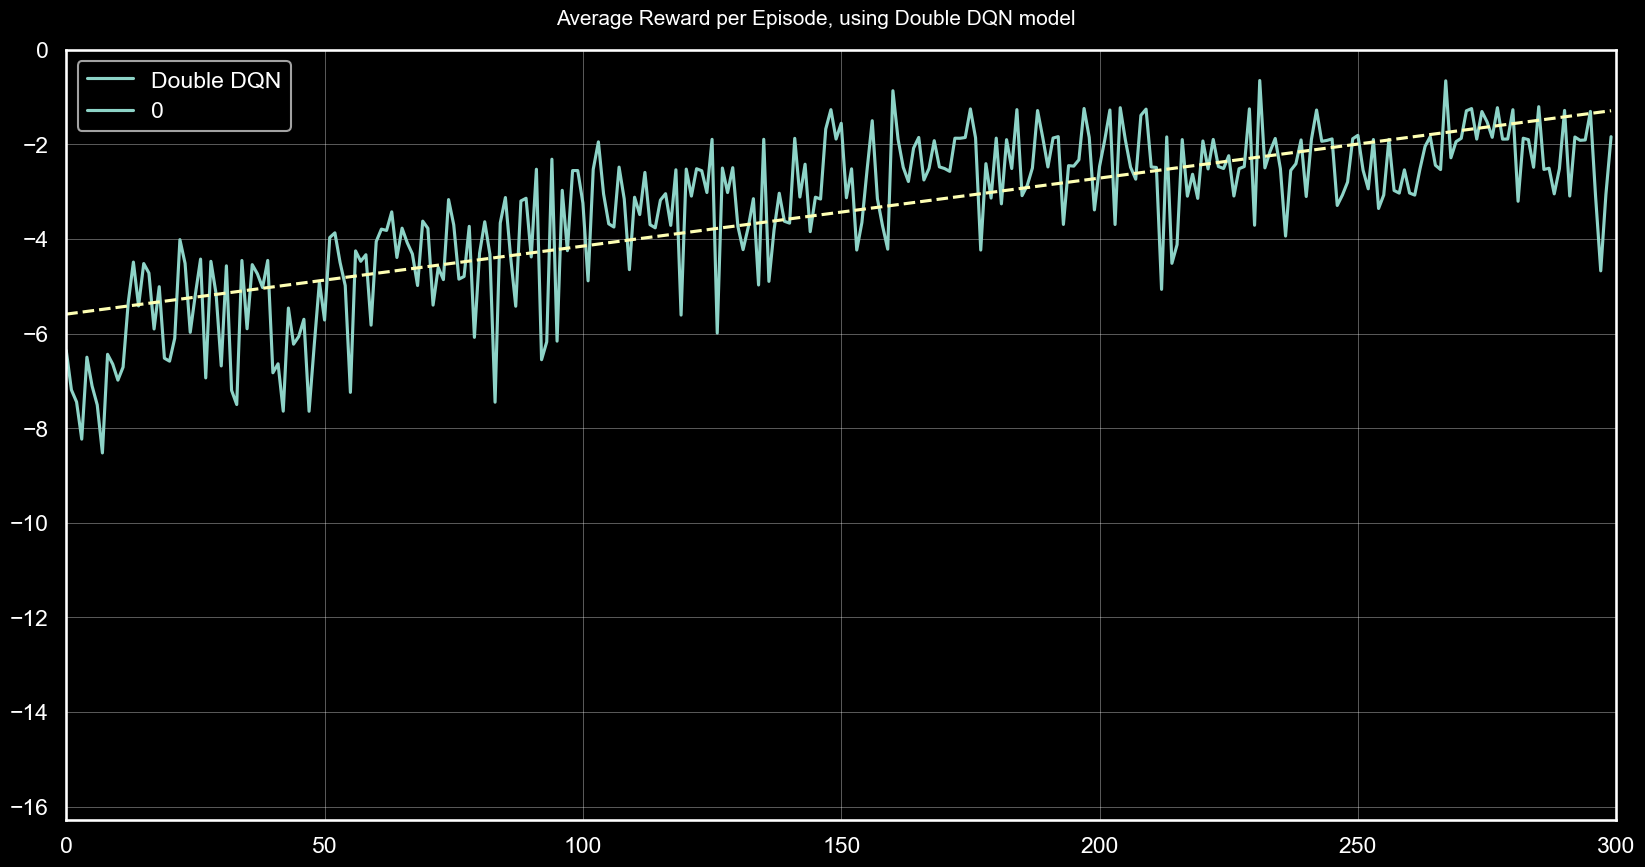

Average reward for test episode: -0.6274638750736966


In [9]:
class DoubleDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, epsilon_decay=0.995, epsilon_min=0.02):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # Replay memory
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.update_target_model()

    # Model Architecture
    def _build_model(self):
        # Init model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        return model

    # Target Network
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Add to experience replay
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Epsilon-Greedy Policy to choose action
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # pull random action (exploration)
            return random.randrange(self.action_size)
        # else pull current-best action (greedy; exploitation)
        act_values = self.model.predict(state, verbose = 0)
        return np.argmax(act_values[0])

    # Replay Buffer
    def replay(self, batch_size):
        # Generate minibatches from replay memory
        minibatch = random.sample(self.memory, batch_size)

        # Extract elements from minibatch
        states = np.array([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])

        # Ensure the states and next_states are correctly shaped
        states = np.reshape(states, (batch_size, self.state_size))
        next_states = np.reshape(next_states, (batch_size, self.state_size))

        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor([float(x[4]) for x in minibatch], dtype=tf.float32)
        dones_bool = tf.cast(dones, dtype=tf.bool)
        
        # Now using dones_bool as the condition
        # Faster training
        with tf.GradientTape() as tape:
            main_q_actions = tf.argmax(self.model(next_states, training=False), axis=1)
            target_q_values = tf.reduce_sum(self.target_model(next_states, training=False) * tf.one_hot(main_q_actions, self.action_size), axis=1)
            target_q_values = rewards + self.gamma * target_q_values * (1 - dones)
            q_values = tf.reduce_sum(self.model(states, training=True) * tf.one_hot(actions, self.action_size), axis=1)
            loss = tf.reduce_mean(tf.square(target_q_values - q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    # Train model
    def train(self, train_length=300, batch_size=32):
        env = gym.make('Pendulum-v1') # Create environment
        done = False
        rewards = []
        average_rewards = []

        for e in range(train_length):
            start_time = time_module.time()
            reward_sum = 0
            state, info = env.reset() #reset environment
            state = np.reshape(state, [1, self.state_size]) # preprocess state

            for time in range(200):
                action = self.act(state) # choose action
                next_state, reward, _, done, _ = env.step([discrete_actions[action]])
                reward = reward if not done else -10

                next_state = np.reshape(next_state, [1, self.state_size]) # preprocess next state
                self.remember(state, action, reward, next_state, done) # store experience in replay memory
                state = next_state # move onto next state

                if done:
                    self.update_target_model()
                    rewards.append(time)
                    break
                if len(self.memory) > batch_size:
                    self.replay(batch_size)

                reward_sum += reward

            average_rewards.append(reward_sum / 200)
            print(f"Episode {e+1}, Epsilon: {self.epsilon:.3f}, Average Episode Reward: {(reward_sum / 200):.4f}, Duration = {time_module.time() - start_time:.2f} seconds", end='\r')
            
            # Decay epsilon gradually
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                
        return rewards, average_rewards
    
ddqn_agent = DoubleDQNAgent(state_size, num_discrete_actions, epsilon_decay=0.995, epsilon_min=0.02)
_, ddqn_reward_arr = ddqn_agent.train(train_length=300)
rlf.plot_results([ddqn_reward_arr], ['DDQN'], "Double DQN")
rlf.env_viz(ddqn_agent, state_size=state_size, discrete_actions=discrete_actions)

<hr>
<font size = 5>Model Selection</font>
<hr>

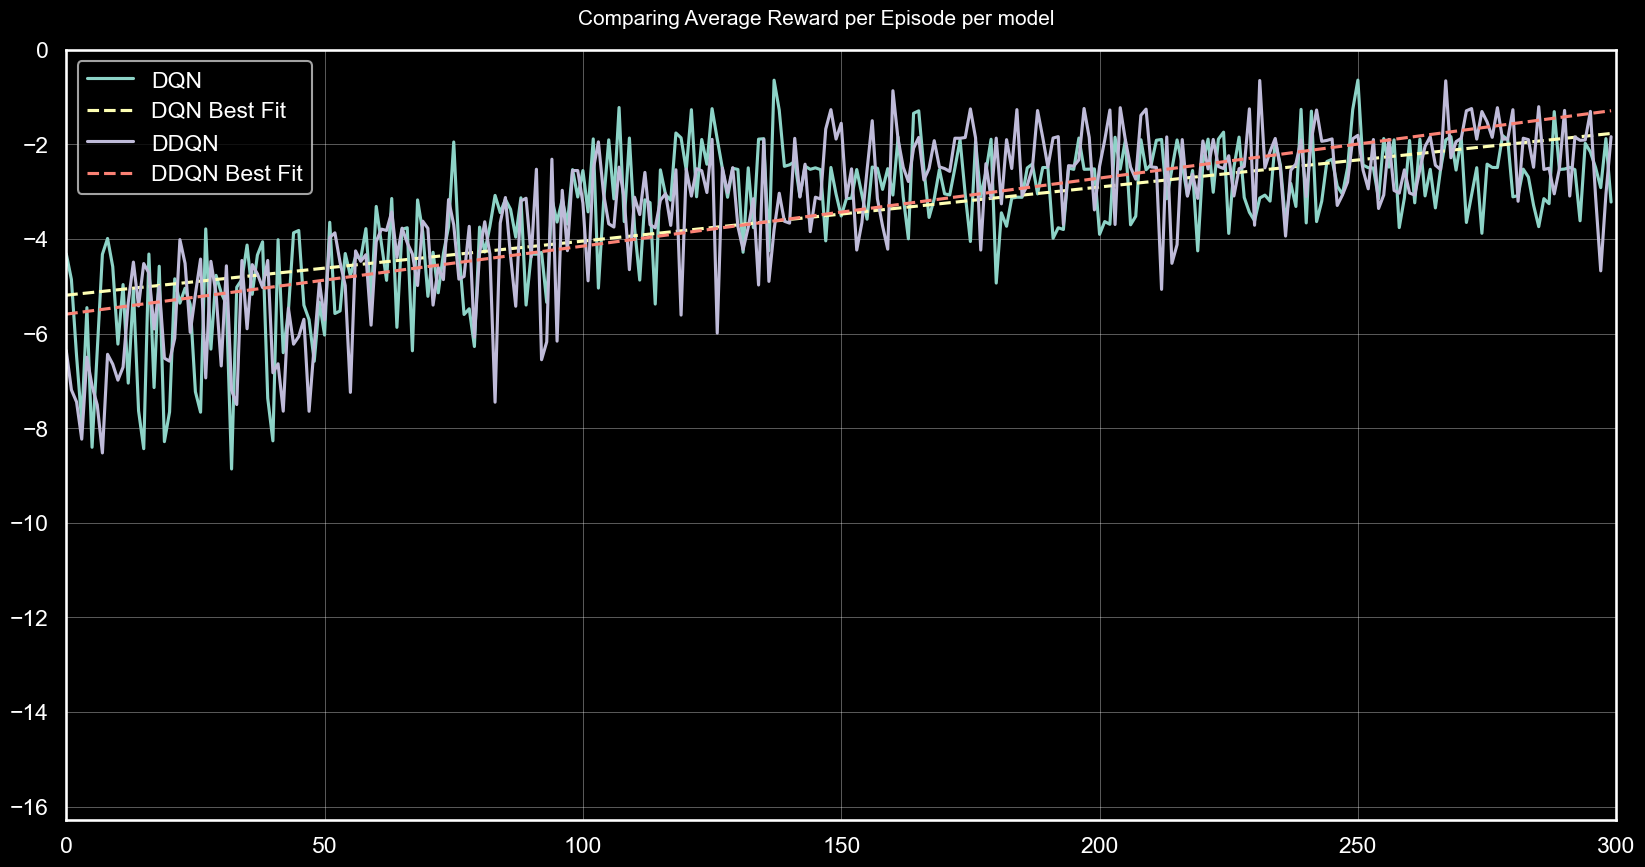

In [10]:
rlf.plot_results([dqn_reward_arr, ddqn_reward_arr], ['DQN', 'DDQN'], "DQN model vs Double DQN")

from this we can see that ddqn is better. while it starts out worse than 

<hr>
<font size = 5>Model Improvement</font>
<hr>

discretize

<b>Huber Loss Function</b>

Instead of using the mean squared loss, use the Huber loss function instead to make the Q-Network more stable.

Sources:<br>
https://lindevs.com/calculate-huber-loss-using-tensorflow-2<br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber

Please input as an array.23, Average Episode Reward: -2.3567, Duration = 15.27 secondsds
Average reward for test episode: -0.5848652288507664


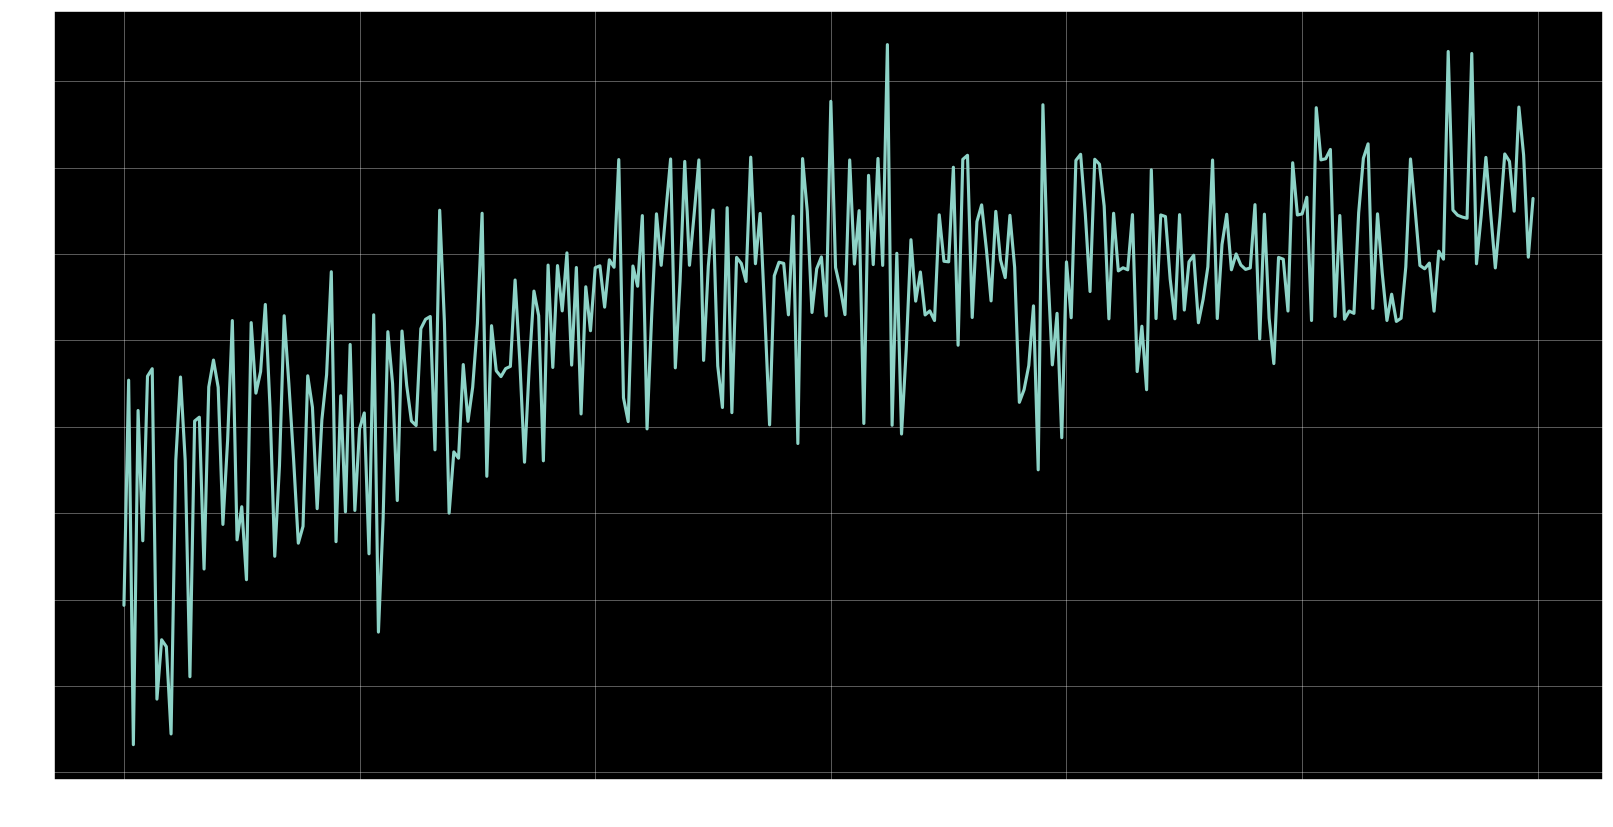

In [10]:
class HuberDoubleDQNAgent(DoubleDQNAgent):
    def __init__(self, state_size, action_size, learning_rate=0.001, epsilon_decay=0.995, epsilon_min=0.02, delta=1.0):
        super().__init__(state_size, action_size, learning_rate, epsilon_decay, epsilon_min)
        self.delta = delta

    # Replay Buffer
    def replay(self, batch_size):
        # Generate minibatches from replay memory
        minibatch = random.sample(self.memory, batch_size)

        # Extract elements from minibatch
        states = np.array([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])

        # Ensure the states and next_states are correctly shaped
        states = np.reshape(states, (batch_size, self.state_size))
        next_states = np.reshape(next_states, (batch_size, self.state_size))

        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor([float(x[4]) for x in minibatch], dtype=tf.float32)
        dones_bool = tf.cast(dones, dtype=tf.bool)
        
        # Now using dones_bool as the condition
        # Faster training
        with tf.GradientTape() as tape:
            main_q_actions = tf.argmax(self.model(next_states, training=False), axis=1)
            target_q_values = tf.reduce_sum(self.target_model(next_states, training=False) * tf.one_hot(main_q_actions, self.action_size), axis=1)
            target_q_values = rewards + self.gamma * target_q_values * (1 - dones)
            q_values = tf.reduce_sum(self.model(states, training=True) * tf.one_hot(actions, self.action_size), axis=1)

            # Use Huber Loss instead of Mean Squared Error (MSE)
            #loss = tf.reduce_mean(tf.losses.huber_loss(target_q_values, q_values, delta=self.delta))
            huber_loss = tf.keras.losses.Huber(delta=self.delta)
            loss = tf.reduce_mean(huber_loss(target_q_values, q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
huber_ddqn_agent = HuberDoubleDQNAgent(state_size, num_discrete_actions, epsilon_decay=0.995, epsilon_min=0.02, delta=1.0)
_, huber_ddqn_reward_arr = huber_ddqn_agent.train(train_length=300)
rlf.plot_results([huber_ddqn_reward_arr], ['Huber DDQN'], "Huber Double DQN")
rlf.env_viz(huber_ddqn_agent, state_size=state_size, discrete_actions=discrete_actions)

Please input as an array.23, Average Episode Reward: -2.5574, Duration = 17.86 seconds
Average reward for test episode: -0.6085680046102464


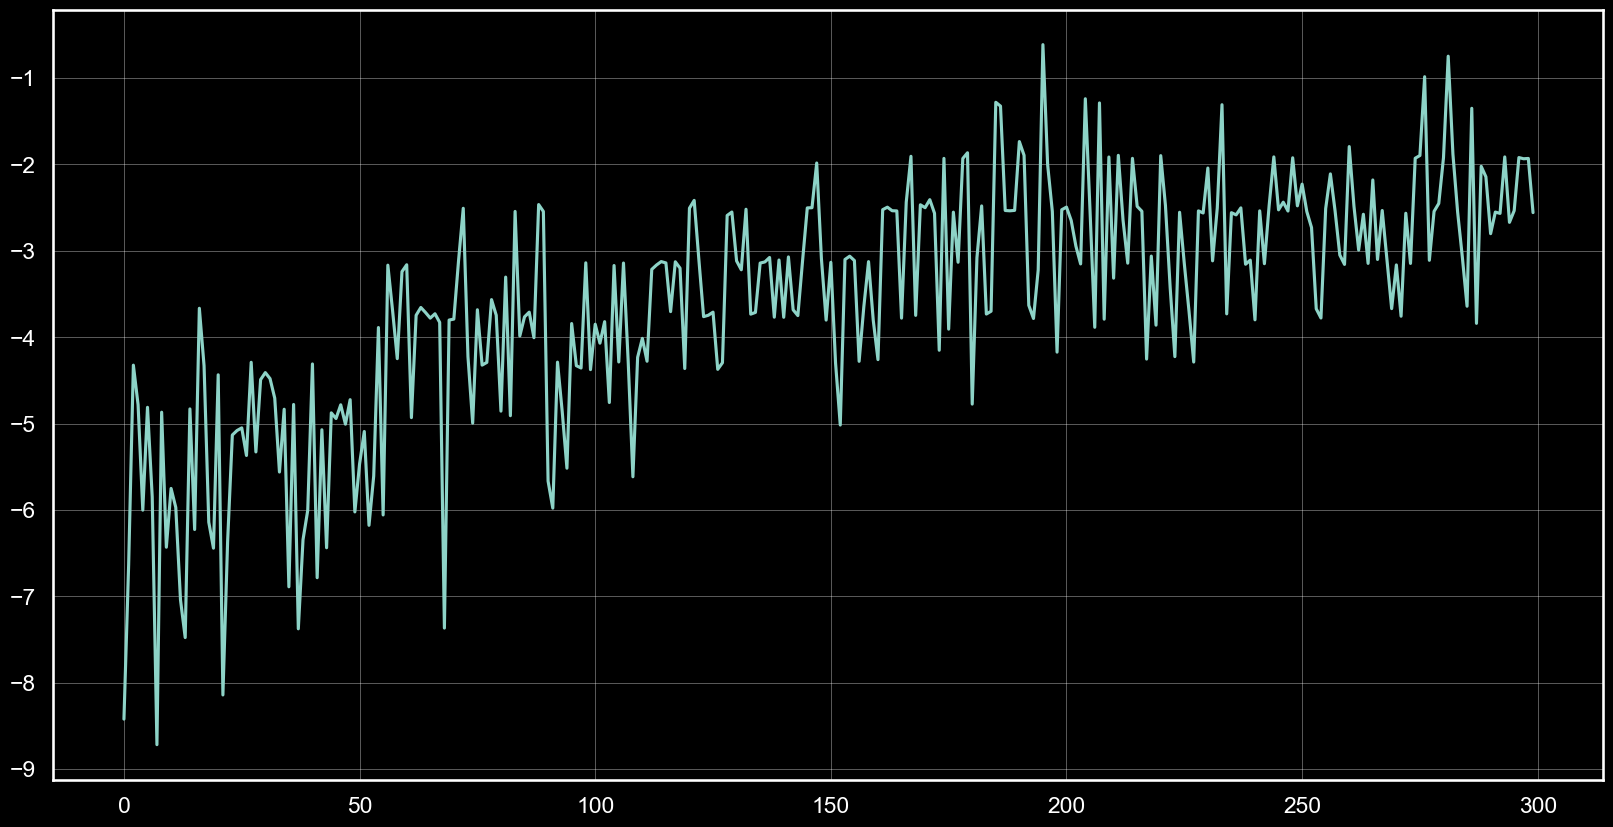

In [13]:
class HuberDoubleDQNAgent(DoubleDQNAgent):
    def __init__(self, state_size, action_size, learning_rate=0.001, epsilon_decay=0.995, epsilon_min=0.02, delta=0.5):
        super().__init__(state_size, action_size, learning_rate, epsilon_decay, epsilon_min)
        self.delta = delta

    # Replay Buffer
    def replay(self, batch_size):
        # Generate minibatches from replay memory
        minibatch = random.sample(self.memory, batch_size)

        # Extract elements from minibatch
        states = np.array([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])

        # Ensure the states and next_states are correctly shaped
        states = np.reshape(states, (batch_size, self.state_size))
        next_states = np.reshape(next_states, (batch_size, self.state_size))

        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor([float(x[4]) for x in minibatch], dtype=tf.float32)
        dones_bool = tf.cast(dones, dtype=tf.bool)
        
        # Now using dones_bool as the condition
        # Faster training
        with tf.GradientTape() as tape:
            main_q_actions = tf.argmax(self.model(next_states, training=False), axis=1)
            target_q_values = tf.reduce_sum(self.target_model(next_states, training=False) * tf.one_hot(main_q_actions, self.action_size), axis=1)
            target_q_values = rewards + self.gamma * target_q_values * (1 - dones)
            q_values = tf.reduce_sum(self.model(states, training=True) * tf.one_hot(actions, self.action_size), axis=1)

            # Use Huber Loss instead of Mean Squared Error (MSE)
            #loss = tf.reduce_mean(tf.losses.huber_loss(target_q_values, q_values, delta=self.delta))
            huber_loss = tf.keras.losses.Huber(delta=self.delta)
            loss = tf.reduce_mean(huber_loss(target_q_values, q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
huber_ddqn_agent_v2 = HuberDoubleDQNAgent(state_size, num_discrete_actions, epsilon_decay=0.995, epsilon_min=0.02, delta=0.5)
_, huber_ddqn_reward_arr_v2 = huber_ddqn_agent_v2.train(train_length=300)
rlf.plot_results([huber_ddqn_reward_arr_v2], ['Huber DDQN Delta 0.5'], "Huber Double DQN Delta 0.5")
rlf.env_viz(huber_ddqn_agent_v2, state_size=state_size, discrete_actions=discrete_actions)

In [15]:
# Save weights
huber_ddqn_agent_v2.model.save_weights('huberDDQN_v2_weights.h5')
huber_ddqn_agent.model.save_weights('huberDDQN_weights.h5')

# Save average rewards per epsiode data
file_path = os.path.join('output', 'huber_ddqn_agent_v1_rewards')
with open(file_path, 'w') as file:
    file.write(str(huber_ddqn_reward_arr))

file_path = os.path.join('output', 'huber_ddqn_agent_v2_rewards')
with open(file_path, 'w') as file:
    file.write(str(huber_ddqn_reward_arr_v2))

In [24]:
rlf.plot_results([huber_ddqn_reward_arr], 'Huber DDQN 1.0', "DQN model vs Double DQN")

Please input as an array.


<Figure size 2000x1000 with 0 Axes>

<hr>
<font size = 5>Model Evaluation</font>
<hr>

<hr>
<font size = 5>Conclusion</font>
<hr>